### Load the Libraries

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Load the Dataset

In [2]:
kidDataset = pd.read_csv("Kid.csv")
kidDataset.head()

,Obs No.,Buy,Income,Is Female,Is Married,Has College,Is Professional,Is Retired,Unemployed,Residence Length,Dual Income,Minors,Own,House,White,English,Prev Child Mag,Prev Parent Mag
0,1,0,24000,1,0,1,1,0,0,26,0,0,0,1,0,0,0,0
1,2,1,75000,1,1,1,1,0,0,15,1,0,1,1,1,1,1,0
2,3,0,46000,1,1,0,0,0,0,36,1,1,1,1,1,1,0,0
3,4,1,70000,0,1,0,1,0,0,55,0,0,1,1,1,1,1,0
4,5,0,43000,1,0,0,0,0,0,27,0,0,0,0,1,1,0,1


In [3]:
kidDataset.shape

(673, 18)

 A distribution of the peope who have bought the magazine and people who haven't based on the number of years they have stayed in that locality

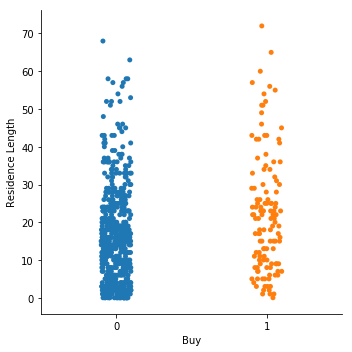

In [4]:
sns.catplot(x='Buy',y='Residence Length',data=kidDataset)

We drop the observation number as it provides no new information.

In [5]:
kidDataset.drop(columns=['Obs No.'],inplace=True);

We now try to find out whether any of the columns have any missing values

In [6]:
kidDataset.isnull().sum()

Buy                 0
Income              0
Is Female           0
Is Married          0
Has College         0
Is Professional     0
Is Retired          0
Unemployed          0
Residence Length    0
Dual Income         0
Minors              0
Own                 0
House               0
White               0
English             0
Prev Child Mag      0
Prev Parent Mag     0
dtype: int64

We determine some baseline columns which we will use to create a baseline model.

In [204]:
baseline_cols=['Is Married','Is Female','Income','Residence Length']

We now see a distribution of the people who have bought the magazine and people who haven't

In [205]:
kidDataset.Buy.value_counts()

0    548
1    125
Name: Buy, dtype: int64

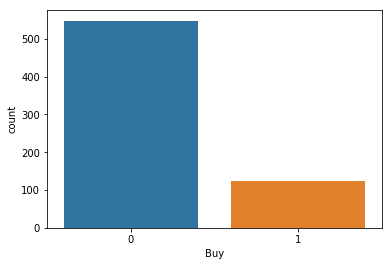

In [206]:
sns.countplot(x='Buy',data=kidDataset)

We seperate out the dependent target variable

In [207]:
y=kidDataset['Buy']

We put all the independent features in a dataframe x 

In [208]:
x=kidDataset.loc[:, kidDataset.columns != 'Buy']

We split the datasets into train and test data 

In [209]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=56,stratify = y)

In [210]:
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(538, 16) (538,)
(135, 16) (135,)


In [211]:
x_train=x_train.reset_index(drop=True)
y_train=y_train.reset_index(drop=True)

Here we a generalized have function which takes in ML algo to be used to train the data, Random state value for reproducibility,threshold value to determine which threshold to use for the classification of the predicted probability and the independent features to use for creating the model. 

It returns the ROC,Recall and Precision Score of each of the Cross Validation dataset in KFold Cross Validation.

In [212]:
def cv_score(model,rstate=12,thres=0.5,cols=x_train.columns):
    i=1
    df=x_train[cols]
    kf=StratifiedKFold(n_splits=6,random_state=rstate,shuffle=True)
    ret_cv_score=[]
    for train_index,test_index in kf.split(df,y_train):
        print('\n{} of kfold {}'.format(i,kf.n_splits))
        x_trn,x_cvl=df.loc[train_index],df.loc[test_index]
        y_trn,y_cvl=y_train.loc[train_index],y_train.loc[test_index]
        
        model.fit(x_trn,y_trn)
        
        pred_prob=model.predict_proba(x_cvl)
        
        pred_y=[]
        for j in pred_prob[:,1]:
            if j > thres:
                pred_y.append(1)
            else:
                pred_y.append(0)
        roc_score=metrics.roc_auc_score(y_cvl,pred_prob[:,1])
        
        recall=metrics.recall_score(y_cvl,pred_y)
       
        precision=metrics.precision_score(y_cvl,pred_y)
        
        msg = "ROC AUC Score: {}, Recall Score: {:.4f}, Precision Score: {:.4f} ".format(roc_score, recall,precision)
        print("{}".format(msg))
        ret_cv_score.append(roc_score)
        i+=1
    return ret_cv_score

In [213]:
all_feature=cv_score(LogisticRegression())


1 of kfold 6
ROC AUC Score: 0.9637389202256245, Recall Score: 0.5294, Precision Score: 0.9000 

2 of kfold 6
ROC AUC Score: 0.9202256244963739, Recall Score: 0.5882, Precision Score: 0.7692 

3 of kfold 6
ROC AUC Score: 0.9097502014504432, Recall Score: 0.5882, Precision Score: 0.6667 

4 of kfold 6
ROC AUC Score: 0.9282836422240129, Recall Score: 0.7059, Precision Score: 0.7500 

5 of kfold 6
ROC AUC Score: 0.9503424657534246, Recall Score: 0.7500, Precision Score: 0.7059 

6 of kfold 6
ROC AUC Score: 0.9006849315068494, Recall Score: 0.6250, Precision Score: 0.5263 


Here we are selecting the features with RFE(Recursive Feature Elimination) method.

In [214]:
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt

# Create the RFE object and rank each feature
model = LogisticRegression()
rfe = RFE(estimator=model, n_features_to_select=1, step=1)
rfe.fit(x_train, y_train)

RFE(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
  n_features_to_select=1, step=1, verbose=0)

In [215]:
ranking_df = pd.DataFrame()
ranking_df['Feature_name'] = x_train.columns
ranking_df['Rank'] = rfe.ranking_

In [216]:
ranked = ranking_df.sort_values(by=['Rank'])
ranked

,Feature_name,Rank
10,Own,1
14,Prev Child Mag,2
12,White,3
2,Is Married,4
4,Is Professional,5
13,English,6
5,Is Retired,7
3,Has College,8
15,Prev Parent Mag,9
8,Dual Income,10


We took the first 10 features according to the RFE rank and create a model based on that.

In [217]:
rfe_top_10_scores = cv_score(LogisticRegression(), cols = ranked['Feature_name'][:5].values)


1 of kfold 6
ROC AUC Score: 0.7921031426269137, Recall Score: 0.3529, Precision Score: 0.6000 

2 of kfold 6
ROC AUC Score: 0.8045930701047542, Recall Score: 0.3529, Precision Score: 0.4615 

3 of kfold 6
ROC AUC Score: 0.8114423851732474, Recall Score: 0.1765, Precision Score: 0.4286 

4 of kfold 6
ROC AUC Score: 0.8730862207896858, Recall Score: 0.3529, Precision Score: 0.8571 

5 of kfold 6
ROC AUC Score: 0.8561643835616438, Recall Score: 0.4375, Precision Score: 0.6364 

6 of kfold 6
ROC AUC Score: 0.8047945205479452, Recall Score: 0.3750, Precision Score: 0.6667 


We took the baseline features and created another model based on that

In [218]:
base_score=cv_score(LogisticRegression(), cols = baseline_cols)


1 of kfold 6
ROC AUC Score: 0.9564867042707493, Recall Score: 0.5882, Precision Score: 1.0000 

2 of kfold 6
ROC AUC Score: 0.9726027397260274, Recall Score: 0.7647, Precision Score: 0.8667 

3 of kfold 6
ROC AUC Score: 0.9460112812248186, Recall Score: 0.8235, Precision Score: 0.7368 

4 of kfold 6
ROC AUC Score: 0.9460112812248187, Recall Score: 0.6471, Precision Score: 0.7333 

5 of kfold 6
ROC AUC Score: 0.9597602739726028, Recall Score: 0.8125, Precision Score: 0.7647 

6 of kfold 6
ROC AUC Score: 0.9246575342465753, Recall Score: 0.7500, Precision Score: 0.6316 


We now do a comparison of the ROC score returned by the K FOld CV by each model

In [219]:
results_df = pd.DataFrame({'baseline':base_score, 'all_feats': all_feature, 'rfe_top_10': rfe_top_10_scores})

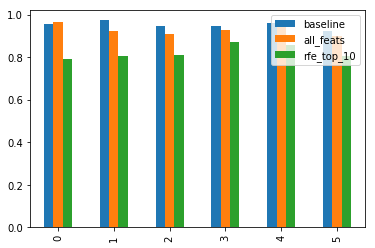

In [220]:
results_df.plot(y=["baseline", "all_feats", "rfe_top_10"], kind="bar")

## Classification Implementation

In [221]:
#x_train=x_train[baseline_cols]
#x_test=x_test[baseline_cols]

In [222]:
log_reg=LogisticRegression()
log_reg.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [223]:
y_pred=log_reg.predict(x_test)

In [224]:
cnf_matrix=metrics.confusion_matrix(y_test,y_pred)
cnf_matrix

array([[100,  10],
       [  5,  20]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

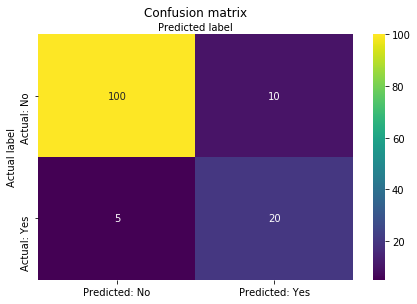

In [225]:
fig, ax = plt.subplots()
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="viridis" ,fmt='g',xticklabels=['Predicted: No','Predicted: Yes'], yticklabels=['Actual: No','Actual: Yes'])
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

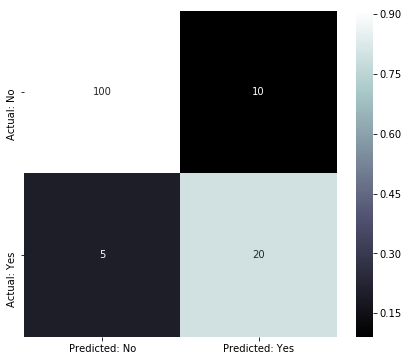

In [226]:
def plot_confusion_matrix(cm, normalized=True, cmap='bone'):
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print(norm_cm)
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=['Predicted: No','Predicted: Yes'], yticklabels=['Actual: No','Actual: Yes'], cmap=cmap)

plot_confusion_matrix(cnf_matrix, ['No', 'Yes'])

In [227]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.8888888888888888
Precision: 0.6666666666666666
Recall: 0.8


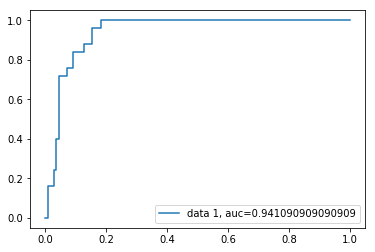

In [228]:
y_pred_proba = log_reg.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

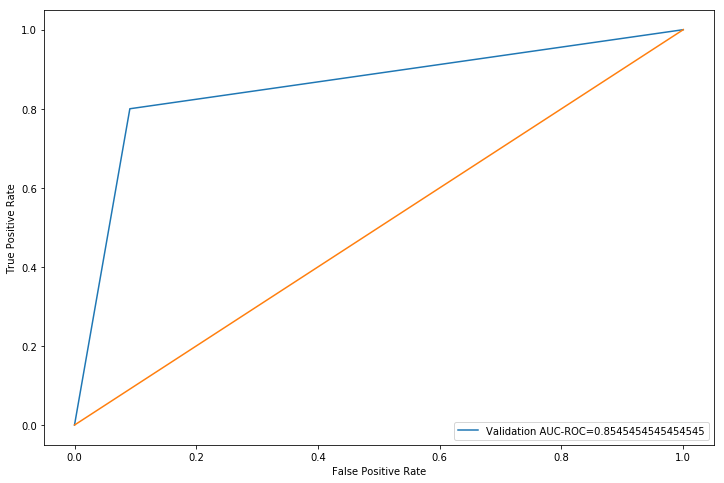

In [229]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test,y_pred) 
auc = metrics.roc_auc_score(y_test, y_pred) 
plt.figure(figsize=(12,8)) 
plt.plot(fpr,tpr,label="Validation AUC-ROC="+str(auc)) 
x = np.linspace(0, 1, 1000)
plt.plot(x, x, linestyle='-')
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.legend(loc=4) 
plt.show()